# Volume Bencharking of External Aero Flows

In this notebook we will walk through the steps required for generating a sample model inference on simulation mesh and compare the model's predictions with the ground truth data across several metrics relevant to the external aerodynamics. This notebook uses the volume results from the [DrivAerML dataset](https://caemldatasets.org/drivaerml/). More specifically, we will use the `202` sample ID to compute all the metrics and comparisons.

## Compute model inference on the benchmark simulation

The benchmark results are saved in `.vtp` and `.vtu` formats for the surface and volume results respectively. For this notebook, let's start with loading up the `.vtu` file and investigating the fields present in it. We will use the `pyvista` library for this purpose. 

---
**NOTE**

The volume files are large for the DrivAerML dataset (each file is ~38 GB). Make sure you have sufficient memory to load the datasets.

---

### Download the benchmark solution

Let's download the solution from the [DrivAerML dataset](https://huggingface.co/datasets/neashton/drivaerml).

In [1]:
import os

filenames = [
    "drivaer_202.stl",
    "volume_202.vtu.00.part",
    "volume_202.vtu.01.part",
]
urls = [
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/drivaer_202.stl",
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/volume_202.vtu.00.part",
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/volume_202.vtu.01.part",
]

for filename, url in zip(filenames, urls):
    if not os.path.exists(filename):
        !wget "{url}" -O "{filename}"
    else:
        print(f"{filename} already exists. Skipping download.")

if not os.path.exists("volume_202.vtu"):
    !cat "volume_202.vtu.00.part" "volume_202.vtu.01.part" > "volume_202.vtu"

drivaer_202.stl already exists. Skipping download.
volume_202.vtu.00.part already exists. Skipping download.
volume_202.vtu.01.part already exists. Skipping download.


In [2]:
import pyvista as pv

mesh = pv.read("./volume_202.vtu")
mesh

UnstructuredGrid (0x7a984a38b880)
  N Cells:    146754704
  N Points:   165122607
  X Bounds:   -4.000e+01, 8.000e+01
  Y Bounds:   -2.200e+01, 2.200e+01
  Z Bounds:   -3.176e-01, 1.968e+01
  N Arrays:   21

We observe that the mesh contains `165122607` points and `146754704` cells. The pressure, velocity and turbulent viscosity variables are stored as `pMeanTrim`, `UMeanTrim` and `nutMeanTrim` respectively. Let's write the model's predictions as `pMeanTrimPred`, `UMeanTrimPred` and `nutMeanTrimPred`. We will compute the inference using the [DoMINO Automotive-Aero NIM](https://docs.nvidia.com/nim/physicsnemo/domino-automotive-aero/latest/overview.html), but one can easily adapt the code to suit the specific model input outputs. Unlike the surface notebook, we will do all the computations for this dataset using the point data. So for the model results too, we will save them on the point data. 

---
**NOTE**

The DOMINO NIM provides flow field inside a very specific bounding box surrounding the car. Specifically the bounding box is extends from -3.5 to 8.5 in x-direction, -2.25 to 2.25 in y-direction and -0.32 to 3.00 in the z-direction. Outside of this bouding box, we will just replace the predictions of the DOMINO model with zeros. 

---

---
**NOTE**

If you are using the Docker container for running this notebook (eg. the [PhysicsNeMo Docker container](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/physicsnemo/containers/physicsnemo)), ensure that you start both the NIM container and the Docker container for this notebook with `--network host` flag, so that the container running the notebook can communicate with the NIM container.

---

---
**IMPORTANT**

We are using the DrivAerML dataset with the DoMINO NIM for this example. The DoMINO NIM is trained on RANS data, while the DrivAerML dataset is generated using RANS-LES (HRLES) simulations. The results from the DoMINO NIM can thus suffer from inaccuracies in the prediction of turbulent quantities (e.g. Turbulent Viscosity and Wall Shear Stress) when compared to the ground truth (HRLES) data. To refer the true performance of DoMINO model architecture, trained on the DrivAerML dataset, please refer to the [Using standardized datasets for inter-model comparison section from README.md](../README.md#using-standardized-datasets-for-inter-model-comparisons).

---

In [ ]:
import numpy as np
import os, time
from physicsnemo.cfd.bench.interpolation.interpolate_mesh_to_pc import (
    _create_nbrs_surface,
    _interpolate,
)
from physicsnemo.cfd.inference.domino_nim import call_domino_nim

output_dict = call_domino_nim(
    stl_path="./drivaer_202.stl",
    inference_api_url="http://localhost:8000/v1/infer",
    data={
        "stream_velocity": "38.89",
        "stencil_size": "1",
        "point_cloud_size": "500000",
    },
    verbose=True,
)
print("Interpolating results on the benchmarking mesh...")

start_time = time.time()
# Interpolate the results of the NIM onto the mesh points
# v2 of NIM supports inference on custom point clouds. 
# you can also pass a custom point cloud directly, however for backwards
# compatability, we will continue the interpolation method. 
# If you wish to infer directly on the point cloud, please uncomment the code
# below and make appropirate changes
# pc_path = "volume_202_pc.npy"
# if not os.path.exists(pc_path):
#     np.save(pc_path, mesh.points)
# 
# output_dict = call_domino_nim(
#     stl_path="./drivaer_202.stl",
#     inference_api_url="http://localhost:8000/v1/infer",
#     data={
#         "stream_velocity": "38.89",
#         "stencil_size": "1",
#     },
#     batch_size=32000,
#     point_cloud="./volume_202_pc.npy",
#     verbose=True,
#     timeout=300,
# )

nbrs_surface = _create_nbrs_surface(
    output_dict["coordinates"][0, :], n_neighbors=3, device="gpu"
)
fields = np.concatenate(
    [
        output_dict["pressure"][0, :],
        output_dict["velocity"][0, :],
        output_dict["turbulent_viscosity"][0, :],
    ],
    axis=1,
)
fields_interp = _interpolate(
    nbrs_surface, mesh.points, fields, device="gpu", batch_size=10_000_000
)
mesh.point_data["pMeanTrimPred"] = fields_interp[:, 0]
mesh.point_data["UMeanTrimPred"] = fields_interp[:, 1:4]
mesh.point_data["nutMeanTrimPred"] = fields_interp[:, 4]
print(f"Interpolation took {time.time() - start_time:.3f} sec")

points = mesh.points
bounds = [-3.5, 8.5, -2.25, 2.25, -0.32, 3.00]
mask = (
    (points[:, 0] >= bounds[0])
    & (points[:, 0] <= bounds[1])
    & (points[:, 1] >= bounds[2])
    & (points[:, 1] <= bounds[3])
    & (points[:, 2] >= bounds[4])
    & (points[:, 2] <= bounds[5])
)

mesh.point_data["pMeanTrimPred"][~mask] = 0.0
mesh.point_data["UMeanTrimPred"][~mask] = 0.0
mesh.point_data["nutMeanTrimPred"][~mask] = 0.0

mesh

Sending POST request to DoMINO NIM inference API at http://localhost:8000/v1/infer...
Inference complete. Output keys: dict_keys(['sdf', 'coordinates', 'velocity', 'pressure', 'turbulent_kinetic_energy', 'turbulent_viscosity', 'bounding_box_dims', 'surface_coordinates', 'pressure_surface', 'wall_shear_stress', 'drag_force', 'lift_force']).
Interpolating results on the benchmarking mesh...
Interpolation took 75.647 sec


UnstructuredGrid (0x7a984a38b880)
  N Cells:    146754704
  N Points:   165122607
  X Bounds:   -4.000e+01, 8.000e+01
  Y Bounds:   -2.200e+01, 2.200e+01
  Z Bounds:   -3.176e-01, 1.968e+01
  N Arrays:   24

Now that we have both the predicted and true fields on the same points, we can start comparing these two solutions.

## L2 Errors

Let's compare the L2 errors for the pressure, velocity and turbulent viscosity fields. We will use the `compute_l2_errors` function from the library. We will pass the `bounds` argument to the `compute_l2_errors` function to restrict the computation only in the region where the model results are available. 

In [4]:
from physicsnemo.cfd.bench.metrics.l2_errors import compute_l2_errors

l2_errors = compute_l2_errors(
    mesh,
    true_fields=["pMeanTrim", "UMeanTrim"],
    pred_fields=["pMeanTrimPred", "UMeanTrimPred"],
    bounds=[-3.5, 8.5, -2.25, 2.25, -0.32, 3.00],
    dtype="point",
)
l2_errors

{'pMeanTrim_l2_error': np.float64(0.6614927749645831),
 'UMeanTrim_x_l2_error': np.float64(0.6885172879055916),
 'UMeanTrim_y_l2_error': np.float64(0.9820704940318181),
 'UMeanTrim_z_l2_error': np.float64(0.8261866318625095)}

The L2 errors are a great way to understand in an aggregate sense, how well the model is performing. However, it does not give much insight into the distribution of the errors. Below, we compute the distribution of the errors (more specifically abs error) as a function of distance from the STL.

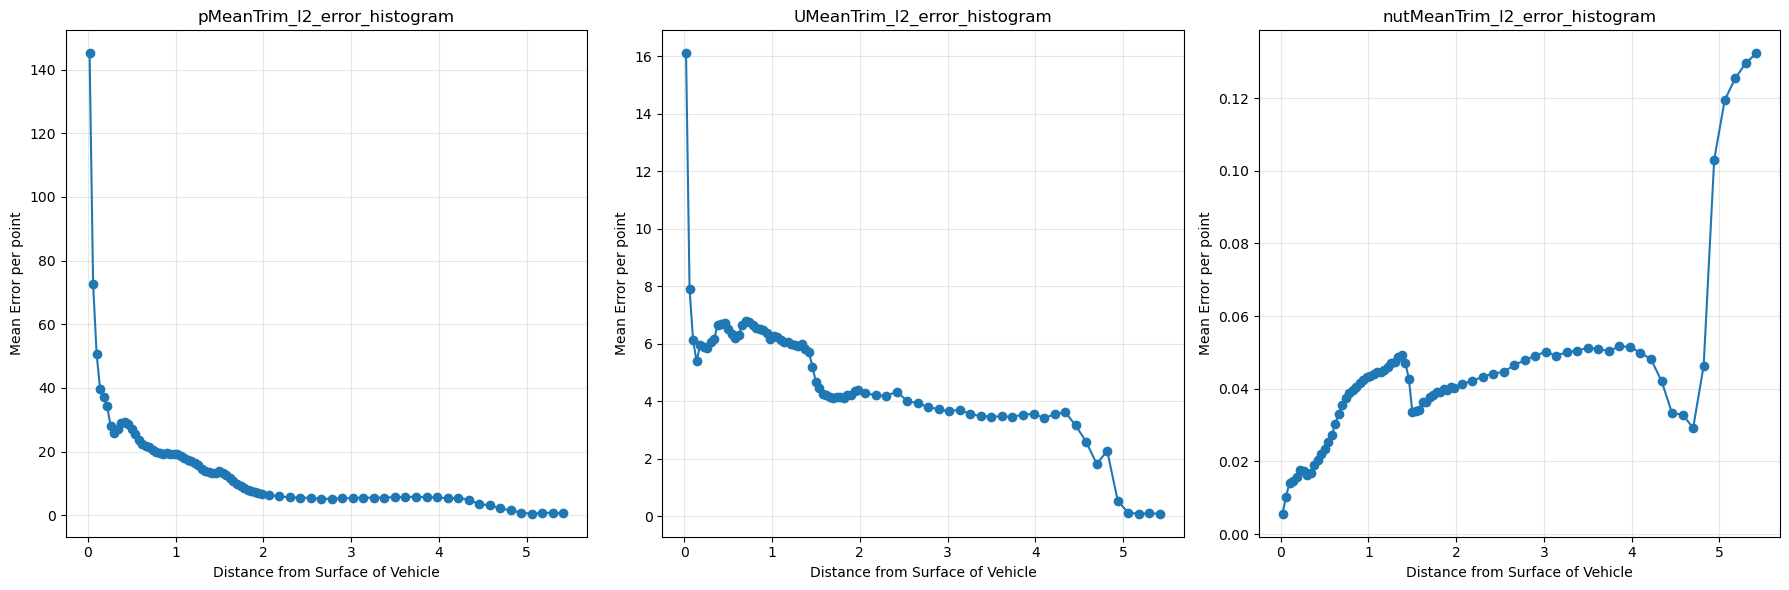

In [ ]:
from physicsnemo.cfd.bench.metrics.l2_errors import compute_error_vs_sdf
import matplotlib.pyplot as plt

# determine query points for sdf
bin_edges = np.linspace(0, 2, 50, endpoint=False)
bin_edges = np.concatenate([bin_edges, np.linspace(2, 8, 51)])

stl_mesh = pv.read("./drivaer_202_single_solid.stl")

output_dict = compute_error_vs_sdf(
    mesh,
    ["pMeanTrim", "UMeanTrim", "nutMeanTrim"],
    ["pMeanTrimPred", "UMeanTrimPred", "nutMeanTrimPred"],
    stl_mesh,
    bin_edges,
    bounds=[-3.5, 8.5, -2.25, 2.25, -0.32, 3.00],
    dtype="point"
)
# print(output_dict)
keys_to_plot = [key for key in output_dict.keys() if "histogram" in key]
fig, axs = plt.subplots(1, len(keys_to_plot), figsize=(18,6))
for i, key in enumerate(keys_to_plot):
    ax = axs[i]
    bin_centers = output_dict[key]["bin_edges"]
    bin_centers = [(a + b) / 2 for a, b in zip(bin_centers, bin_centers[1:])]
    errors = output_dict[key]["mean_errors"]
    ax.plot(bin_centers, errors, marker='o')
    ax.set_title(key)
    ax.set_xlabel('Distance from Surface of Vehicle')
    ax.set_ylabel('Mean Error per point')
    ax.grid(True, alpha=0.3)
plt.tight_layout()

We observe that for pressure and velocity, the error is higher closer to the surface of the STL, while for the turbulent viscosity, the behavior is reversed. This can be useful in deciding the model architecture or loss weighting schemes. Below we show how this distribution looks like when computed across entire validation dataset from DrivAerML.

![Aggregate Error as a function of SDF](img/error_vs_sdf.png)


## Plotting fields

A lot of analysis of the volumetric data relies on visualizing the flow field for specific features of imporance. Let's create some slices and use the `plot_field_comparisons` to create the visuals. 


In [ ]:
# Create a slice that runs along the centerline
y_slice = mesh.slice(normal="y", origin=(0, 0, 0))
y_slice = y_slice.clip_box(bounds, invert=False)

# Create a slice to visualize the wake of the car
x_4_slice = mesh.slice(normal="x", origin=(4, 0, 0))
x_4_slice = x_4_slice.clip_box(bounds, invert=False)

# Create a slice normal to z axis to visualize the wheel wakes
z_neg_0_2376_slice = mesh.slice(normal="z", origin=(0, 0, -0.2376))
z_neg_0_2376_slice = z_neg_0_2376_slice.clip_box(bounds, invert=False)

2025-08-01 00:21:25.101 ( 554.794s) [    7313BFF83740]      vtkPolyhedron.cxx:1758  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2025-08-01 00:21:25.338 ( 555.031s) [    7313BFF83740]      vtkPolyhedron.cxx:1758  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2025-08-01 00:21:35.982 ( 565.675s) [    7313BFF83740]      vtkPolyhedron.cxx:1758  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2025-08-01 00:21:36.374 ( 566.067s) [    7313BFF83740]      vtkPolyhedron.cxx:1758  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2025-08-01 00:21:53.402 ( 583.094s) [    7313BFF83740]      vtkPolyhedron.cxx:1758  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2025-08-01 00:22:00.467 ( 590.160s) [    7313BFF83740]      vtkPolyhedron.cxx:17

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


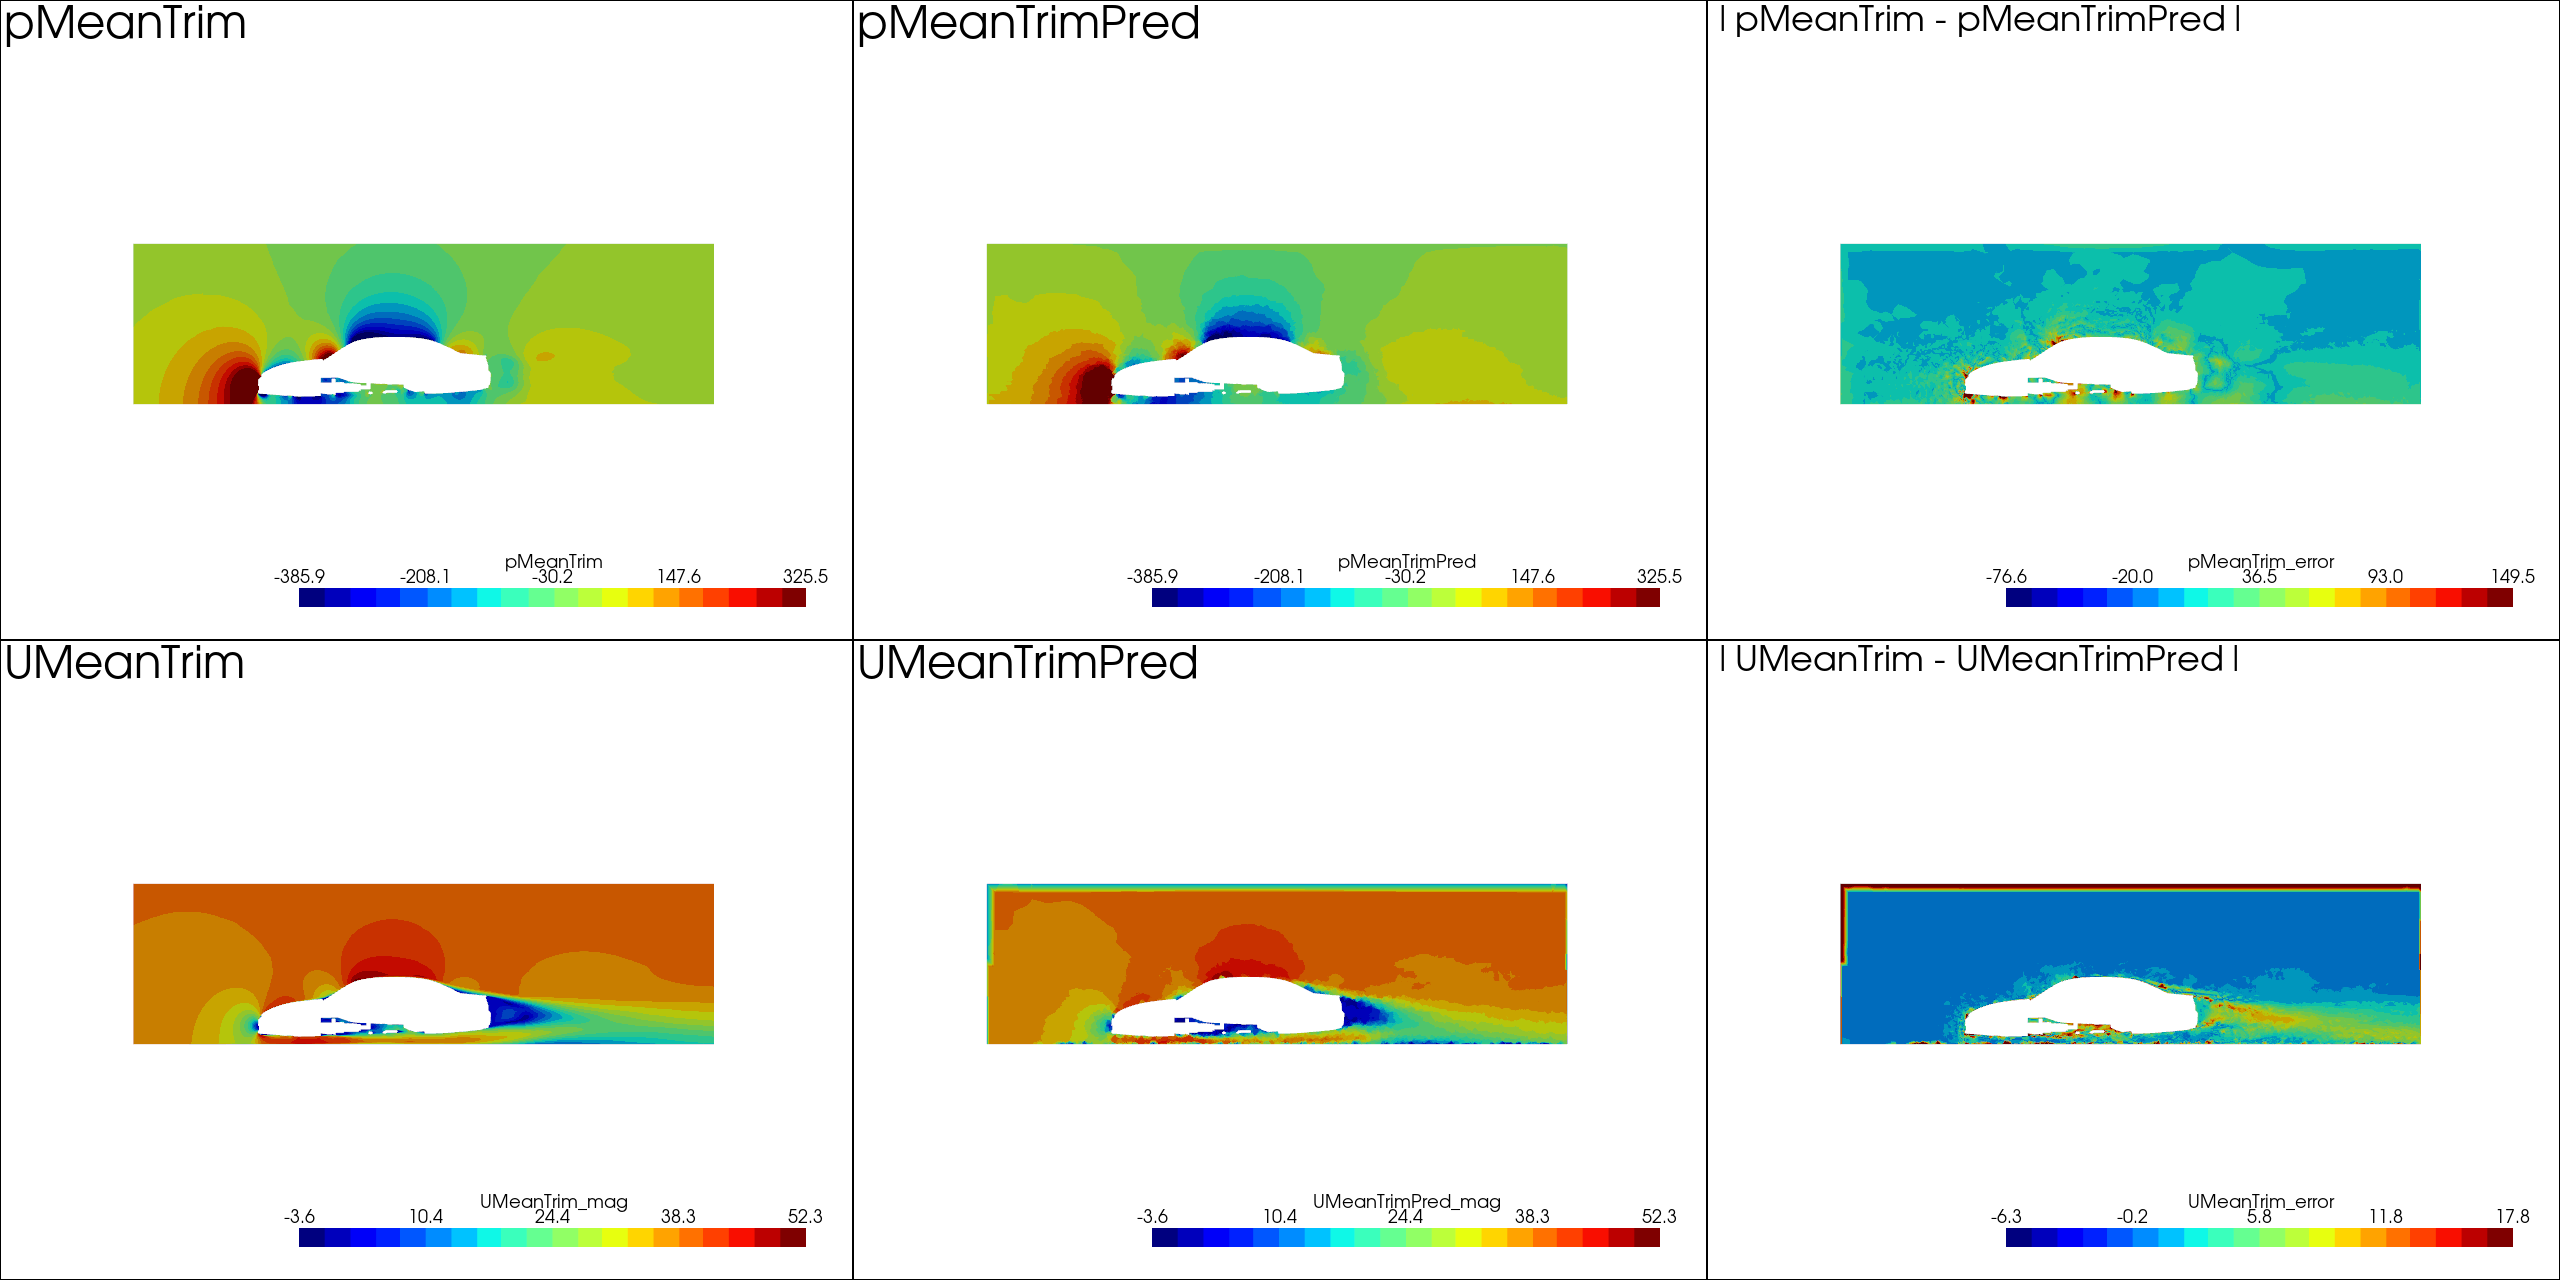

In [ ]:
from physicsnemo.cfd.bench.visualization.utils import plot_field_comparisons

pv.start_xvfb()

plotter = plot_field_comparisons(
    y_slice,
    true_fields=["pMeanTrim", "UMeanTrim"],
    pred_fields=["pMeanTrimPred", "UMeanTrimPred"],
    plot_vector_components=False,
    view="xz",
    dtype="point",
    cmap="jet",
    lut=20,
    window_size=[2560, 1280],
)

plotter.screenshot("./sample_202_volume_y_slice_comparison.png")

# Display the image
from IPython.display import Image

Image(filename="./sample_202_volume_y_slice_comparison.png")

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


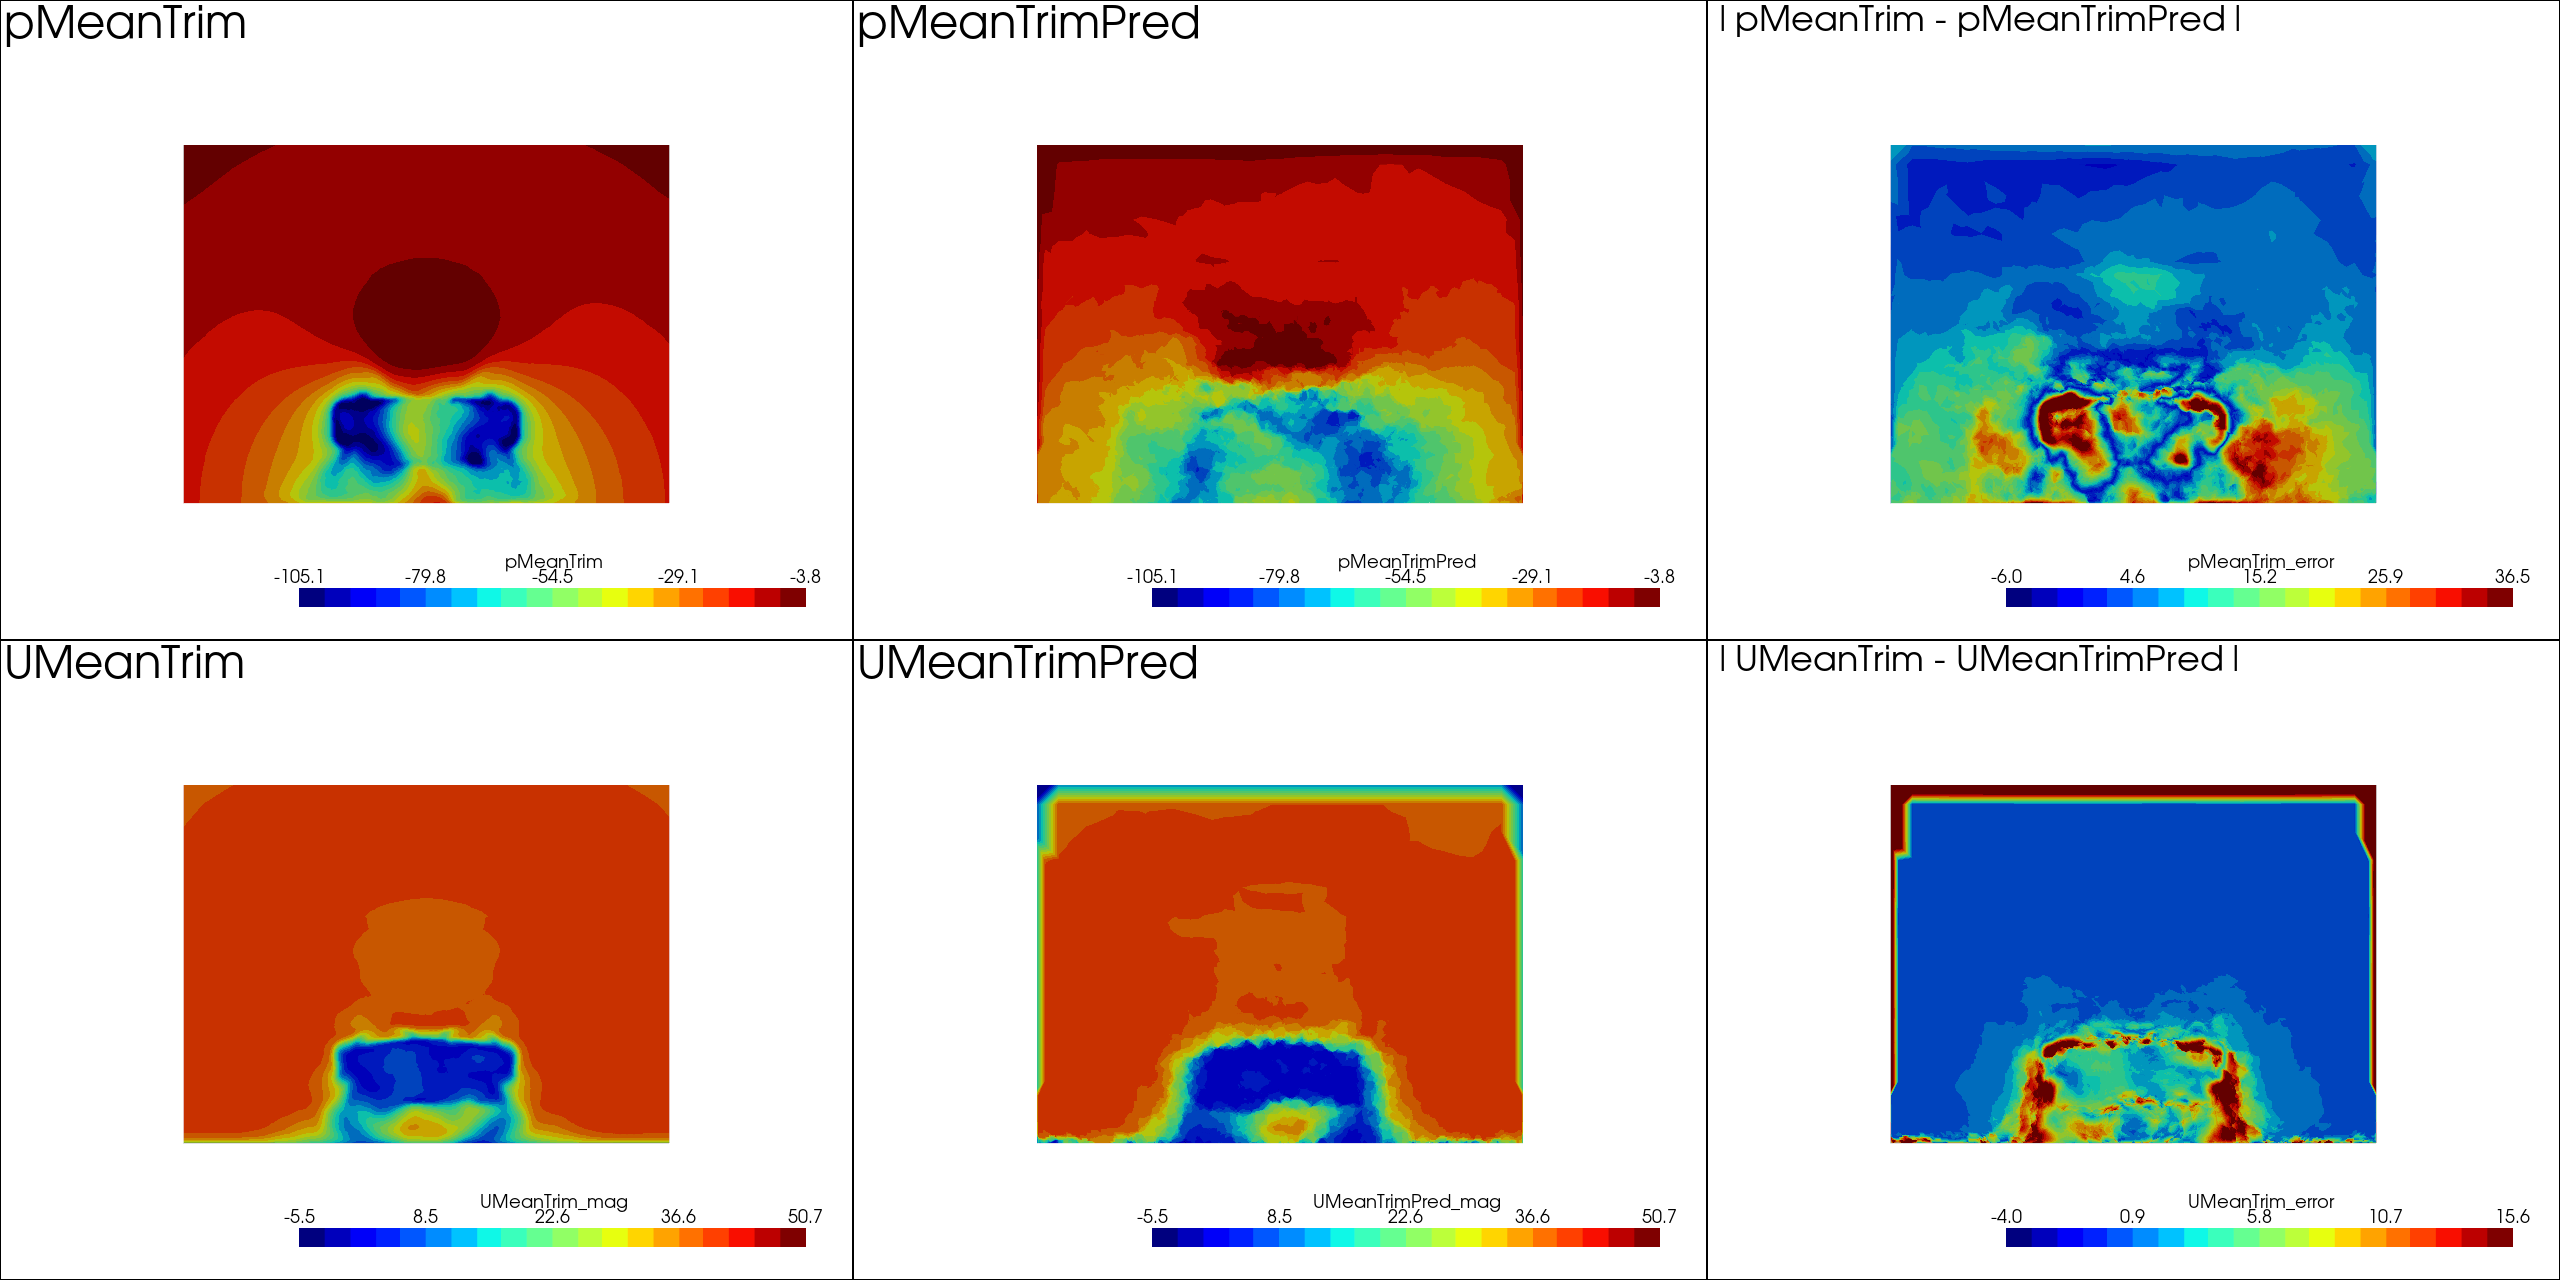

In [ ]:
plotter = plot_field_comparisons(
    x_4_slice,
    true_fields=["pMeanTrim", "UMeanTrim"],
    pred_fields=["pMeanTrimPred", "UMeanTrimPred"],
    plot_vector_components=False,
    view="yz",
    dtype="point",
    cmap="jet",
    lut=20,
    window_size=[2560, 1280],
)

plotter.screenshot("./sample_202_volume_x_4_slice_comparison.png")

# Display the image
from IPython.display import Image

Image(filename="./sample_202_volume_x_4_slice_comparison.png")

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


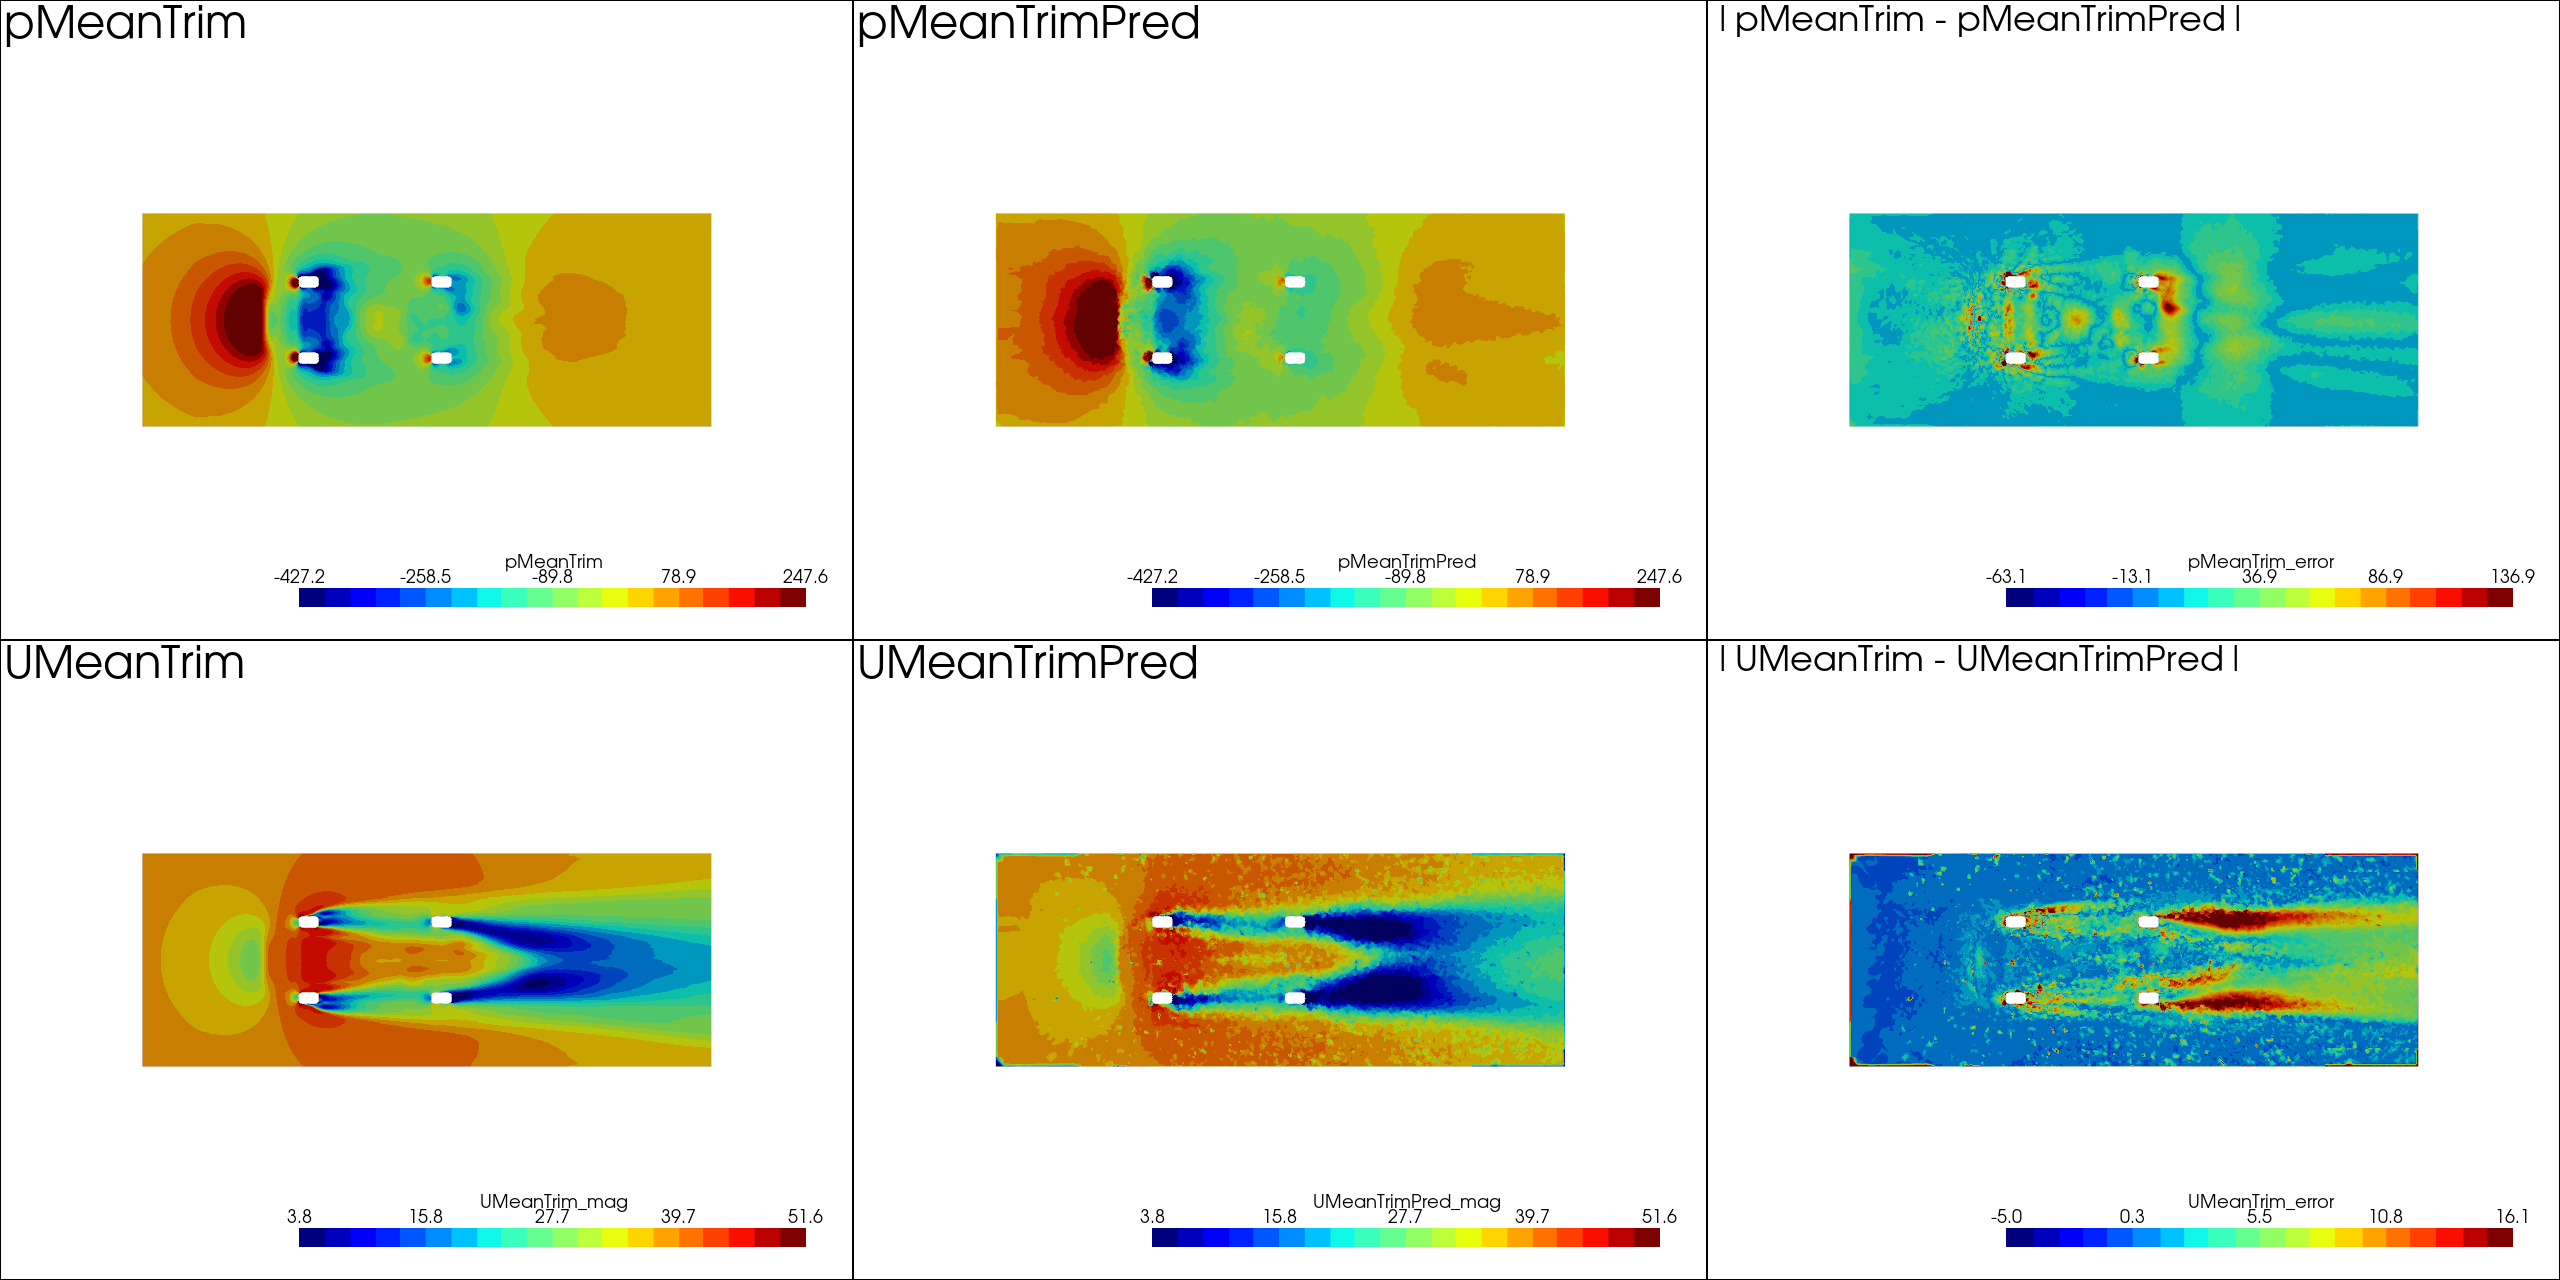

In [ ]:
plotter = plot_field_comparisons(
    z_neg_0_2376_slice,
    true_fields=["pMeanTrim", "UMeanTrim"],
    pred_fields=["pMeanTrimPred", "UMeanTrimPred"],
    plot_vector_components=False,
    view="xy",
    dtype="point",
    cmap="jet",
    lut=20,
    window_size=[2560, 1280],
)

plotter.screenshot("./sample_202_volume_z_slice_comparison.png")

# Display the image
from IPython.display import Image

Image(filename="./sample_202_volume_z_slice_comparison.png")

The visualization of the slices reveals that the AI prediction is able to capture the larger structures in the flow field. The predictions are generally a bit noisy, some of which can be attributed to the interpolation of the NIM results from ~500k points to ~160M points. 

Such visualizations do not provide feedback on how the predictions look visually across the entire validaton dataset. For such comparison, one can project the errors from different samples on fixed points and then use those points to build aggregate visualizations. The [`../generate_volume_benchmarks.py`](../generate_volume_benchmarks.py) script provides such capabilities.  

Below we show the error distribution across the entire validation set of DrivAerML (visualized with Sample ID 439 (largest STL from DrivAerML in terms of geometric size)). 

![Aggregate Errors](img/resampled_volume_errors.png)

The plots indicate that overall, the errors are typically higher in the wake of the car for velocity, closer to the car surface for pressure and in the farfield for the turbulent viscosity. 

Such analysis can be especially useful when the geometric difference between the samples is not huge (e.g. DrivAerML), where resampling techniques like these to build aggregated visualizations is justified.

Let's also create some line plots for a more detailed visulaization. Here, we will visualize the wake behind the wheels and flow along the centerline under the car very similar to the results presented in the [DrivAerML paper](https://arxiv.org/abs/2408.11969). 

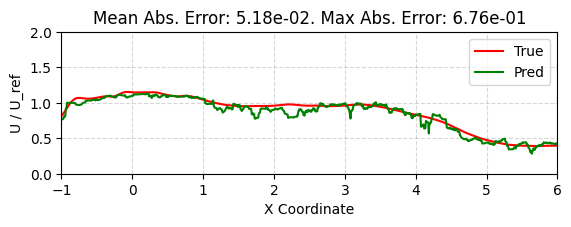

In [ ]:
from physicsnemo.cfd.bench.visualization.utils import plot_line

centerline_bottom = y_slice.slice(normal="z", origin=(0, 0, -0.2376))

fig = plot_line(
    centerline_bottom,
    plot_coord="x",
    field_true="UMeanTrim",
    field_pred="UMeanTrimPred",
    normalize_factor=38.889,
    coord_trim=(-1.0, 6.0),
    field_trim=(0, 2.0),
    flip=False,
    true_line_kwargs={"color": "red", "label": "True"},
    pred_line_kwargs={"color": "green", "label": "Pred"},
    xlabel="X Coordinate",
    ylabel="U / U_ref",
)

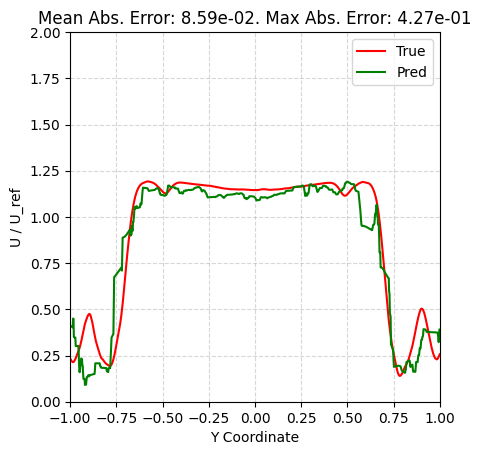

In [ ]:
front_wheel_wake = z_neg_0_2376_slice.slice(normal="x", origin=(0.35, 0, 0))

fig = plot_line(
    front_wheel_wake,
    plot_coord="y",
    field_true="UMeanTrim",
    field_pred="UMeanTrimPred",
    normalize_factor=38.889,
    coord_trim=(-1.0, 1.0),
    field_trim=(0, 2.0),
    flip=False,
    true_line_kwargs={"color": "red", "label": "True"},
    pred_line_kwargs={"color": "green", "label": "Pred"},
    xlabel="Y Coordinate",
    ylabel="U / U_ref",
)

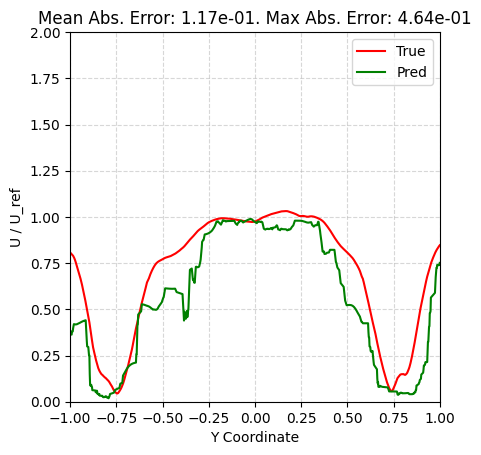

In [ ]:
rear_wheel_wake = z_neg_0_2376_slice.slice(normal="x", origin=(3.15, 0, 0))

fig = plot_line(
    rear_wheel_wake,
    plot_coord="y",
    field_true="UMeanTrim",
    field_pred="UMeanTrimPred",
    normalize_factor=38.889,
    coord_trim=(-1.0, 1.0),
    field_trim=(0, 2.0),
    flip=False,
    true_line_kwargs={"color": "red", "label": "True"},
    pred_line_kwargs={"color": "green", "label": "Pred"},
    xlabel="Y Coordinate",
    ylabel="U / U_ref",
)

Generally speaking, the line plots show good correlation of the AI model results with the ground-truth. However, the model seems to struggle to capture the wake behavior.

That completes the volume benchmarking notebook. For surface benchmarking, refer [`surface_benchmarking.ipynb`](./surface_benchmarking.ipynb). For running the metrics shown here on a several geometries / cases, refer to [`../generate_volume_benchamrks.py`](../generate_volume_benchmarks.py).

## Bonus: Computing the Equation Residuals

Continuity and the Momentum Equations (Navier-Stokes) are the fundamental equations that govern the fluid dynamics of the external aero. We can use the library to measure how well the model's results capture the mass and energy balances. We can use the `compute_continuity_residuals` and `compute_momentum_residuals` functions for these.

---
**NOTE**

Due the the large size of the mesh, this computation can take a few minutes. If you are not interested in the this metric, you can skip the below code blocks. 

---

In [ ]:
from physicsnemo.cfd.bench.metrics.physics import (
    compute_continuity_residuals,
    compute_momentum_residuals,
)

# Let's clip the mesh to work on a smaller dataset
# Set crinkle=True for faster clipping
clipped_mesh = mesh.clip_box(
    bounds=[-2, 6, -0.20, 0.20, -0.32, 3.00],
    invert=False,
    progress_bar=True,
    merge_points=False,
    crinkle=True,
)

# Compute continuity
clipped_mesh = compute_continuity_residuals(
    clipped_mesh,
    true_velocity_field="UMeanTrim",
    predicted_velocity_field="UMeanTrimPred",
)

# Optionally, compute momentum using RANS equations
nu = 1.507e-5
rho = 1.0
clipped_mesh = compute_momentum_residuals(
    clipped_mesh,
    true_velocity_field="UMeanTrim",
    predicted_velocity_field="UMeanTrimPred",
    true_pressure_field="pMeanTrim",
    predicted_pressure_field="pMeanTrimPred",
    true_nu_field="nutMeanTrim",
    predicted_nu_field="nutMeanTrimPred",
    nu=nu,
    rho=rho,
)

Clipping a Dataset by a Bounding Box: 100%|█[04:26<00:00]


Note that the above two functions will create additional fields for `Continuity`, `ContinuityPred`, `Momentum` and `MomentumPred`. The resulting mesh files can be processed as before. For the purposes of this notebook, let's plot the the fields along the mid-y slice. 

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


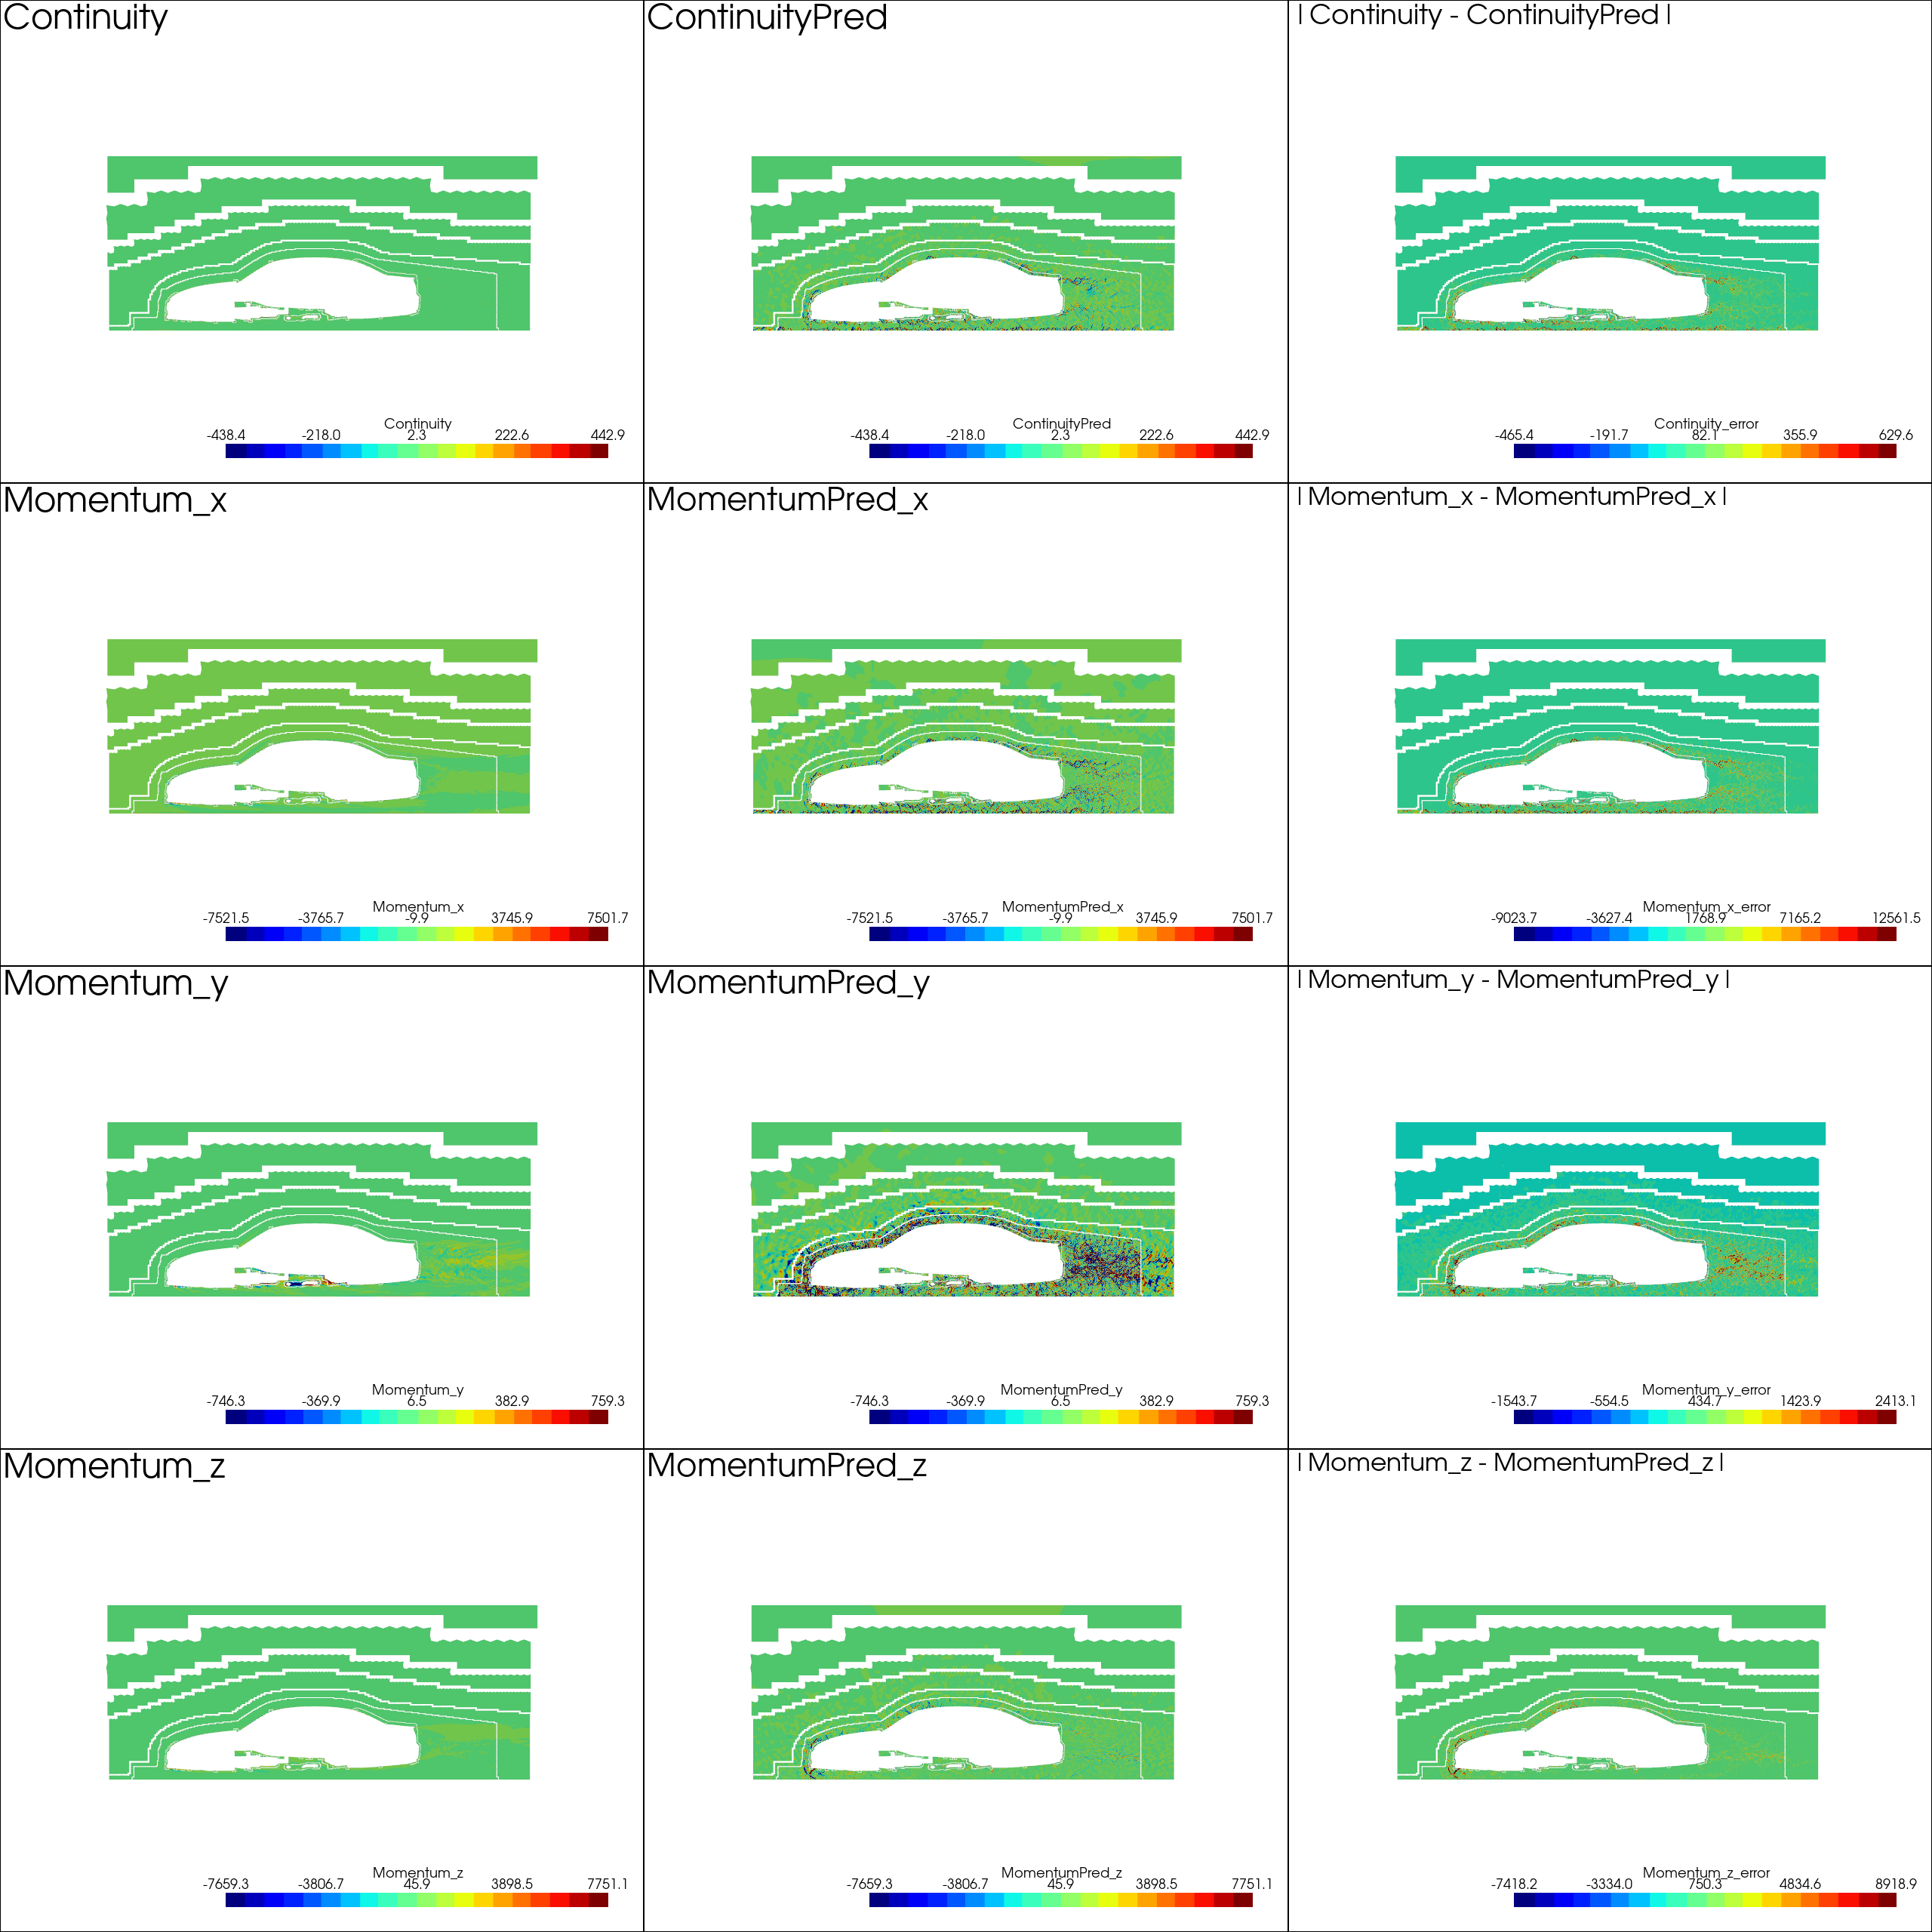

In [ ]:
y_slice = clipped_mesh.slice(normal="y", origin=(0, 0, 0))
y_slice = y_slice.clip_box(bounds, invert=False)

plotter = plot_field_comparisons(
    y_slice,
    true_fields=["Continuity", "Momentum"],
    pred_fields=["ContinuityPred", "MomentumPred"],
    plot_vector_components=True,
    view="xz",
    dtype="point",
    cmap="jet",
    lut=20,
    window_size=[2560, 2560],
)

plotter.screenshot("./sample_202_volume_y_slice_residuals_comparison.png")

# Display the image
from IPython.display import Image

Image(filename="./sample_202_volume_y_slice_residuals_comparison.png")

The predicted residuals show good adherence of the model predictions to the governing laws. The residuals are generally seen to be higher in the wake area or the areas of high shear.

We can also compute the residuals in an integral sense. For example, below code demonstrates integral continuity computed on a box surrounding the car.

In [13]:
from physicsnemo.metrics.cae.integral import surface_integral
from physicsnemo.cfd.bench.interpolation.interpolate_mesh_to_pc import interpolate_mesh_to_pc

# Define a box smaller than the overall bounding box
integral_box_bounds = [-2, 5, -1.5, 1.5, -0.2, 1.5]
integral_box = pv.Box(integral_box_bounds, level=40)
integral_box = interpolate_mesh_to_pc(integral_box, mesh, ["UMeanTrim", "UMeanTrimPred"], mesh_dtype="point")

integrals = surface_integral(integral_box)
integrals

{'integral_UMeanTrim': array([-1.41115921]),
 'integral_UMeanTrimPred': array([19.75796548]),
 'integral_Normals': array([75.99999984])}

 We can observe that the integral continuity (integral U) for the predicted result is further away from 0 compared to the true result. It is quite interesting however to note that even the true solution does not respect the continuity perfectly. 